In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Tutorial-ForexForecasting: Project for testing Forex time series forecasting

**Notebook number 2/2**

This is another short deep learning tutorial to show how to implement Forex time series forecasting using the cookiecutter Deep Learning template: https://github.com/tdeboissiere/cookiecutter-deeplearning

This template is very flexible and clear, but sometimes is not evidence for inexperienced programmer nor deep learning beginners how to use it.

This code is a Forex adaptation of the stock prediction from: https://github.com/sebastianheinz/stockprediction

In notebook 1/2, we read the data from zipped .csv files and create a sqlite database.

We renamed files and variables just following the template example notation. Also, this notation is very often used in Keras documentation. So we prefer to notate the X train matrix as "X_train" and not "Train_X". In this notebook fully implement the deep learning template folder and files structure.

Finally we have to say that in some parts of the code, we have abused of pandas dataframes only with the aim of getting clear printable landscape of he working data. These lines of code is indicated with the comment "...as dataframe" and may be avoided if you translate this notebook to python scripts.

# Tutorial-ForexForecasting

To make the code reproducible.

In [2]:
%load_ext watermark
%watermark -a 'Ram' -u -d -p numpy,scipy,matplotlib,sklearn

Ram 
last updated: 2018-07-11 

numpy 1.13.3
scipy 1.0.1
matplotlib 2.0.2
sklearn 0.19.1


# 1. Forex Forecasting

### 1. Import libraries and modules. Load env variables

In [3]:
## 1. Import libraries and modules. Load env variables
import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import sqlite3
from datetime import date, datetime, timezone
from dotenv import find_dotenv, load_dotenv

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

#Reads the key,value pair from .env and adds them to environment variable 
load_dotenv(find_dotenv())

# Check the env variables exist. Check as many variables as you need
raw_msg = "Set your raw data absolute path in the .env file at project root"
assert "RAW_DIR" in os.environ, raw_msg
data_msg = "Set your processed data absolute path in the .env file at project root"
assert "DATA_DIR" in os.environ, data_msg
interim_msg = "Set your interim data absolute path in the .env file at project root"
assert "INTERIM_DIR" in os.environ, interim_msg

# Load env variables
proj_dir = os.path.expanduser(os.environ.get("PROJ_DIR"))
data_dir = os.path.expanduser(os.environ.get("DATA_DIR"))
raw_dir = os.path.expanduser(os.environ.get("RAW_DIR"))
interim_dir = os.path.expanduser(os.environ.get("INTERIM_DIR"))
processed_dir = os.path.expanduser(os.environ.get("PROCESSED_DIR"))
figures_dir = os.path.expanduser(os.environ.get("FIGURES_DIR"))
model_dir = os.path.expanduser(os.environ.get("MODEL_DIR"))
external_dir = os.path.expanduser(os.environ.get("EXTERNAL_DIR"))

# Import our project modules
#
#Add src/app to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/app"))

#Add src/data to the PATH
sys.path.append(os.path.join(proj_dir,"src/data"))
#Ram import make_dataset as md

#Add src/visualization to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/visualization"))
#Ram import visualize as vs

#Data files
#raw_data = 
#interim_data = 

### 2. Download raw data sets

The great people at [HistData.com](http://www.histdata.com/) have setup the infrastructure necessary to provide you FOREX data for free. This is awesome and if possible, you should donate or purchase some of their services to help them. There exist several tools contained in the internet to download the data, but all of them need your carefully atention. For example:
* https://github.com/philipperemy/FX-1-Minute-Data
* https://github.com/xeb/forex-histdata-etl
* https://gist.github.com/EvianZhow/93b30edb5e1ac44f3dd2de7ef9a543d9

I include forex time series zipped files needed in this tutorial

In [4]:
## 2. Download raw data sets

#This point must be adapted for each project


Download .csv data file from [HistData.com](http://www.histdata.com/) and save in ../data/raw dir

# 2. Basic Data Preparation

Machine Learning time series algorithms usuallly require data to be into a single text file in tabular format, with each row representing a timestamp of the input dataset and each column one of its features.

"Prepare” data for Machine Learning is a complex task depending on where the data is stored and where it is obtained from. And doubtless, it is one of the most time consumption task. Often the Forex data is not available in a single file. They may be distributed across different sources like multiple compressed CSV files, spreadsheets or plain text files, normalized in database tables, or even in NoSql database like MongoDB. So we need a tool to stage, filter, transform when necessary, and finally export to a single flat, text CSV file.

If your Forex data is small and the changes are simple such as adding a derived field or new events you can use a spreadsheet, make the necessary changes, and then export it to a CSV file. Certainly, not too professional. But when the changes are more complex; e.g., joining several sources, filtering a subset of the data, or managing a large amount of timestamp rows, you might need a more powerful tool like an RDBMS. MySQL is a great one and it’s free, and opensourced. In this tutorial, we have selected SQLite which is enough for our purpose and data size. Here we treat several compressed .csv files distributed in different folders, which is very usual in real trading. If the data size that we are managing is in the terabytes, then we should consider Hadoop. But trustus, that is another story.

In [1]:
Image(filename='../docs/images/sqlite_transformations.png', width=500) 

NameError: name 'Image' is not defined

In [6]:
# All available instruments to trade with
all_symbols = ["EURUSD" ,
           "AUDNZD" ,
           "AUDUSD" ,
           "AUDJPY" ,
           "EURCHF" ,
           "EURGBP" ,
           "EURJPY" ,
           "GBPCHF" ,
           "GBPJPY" ,
           "GBPUSD" ,
           "NZDUSD" ,
           "USDCAD" ,
           "USDCHF" ,
           "USDJPY" ,
           "CADJPY" ,
           "EURAUD" ,
           "CHFJPY" ,
           "EURCAD" ,
           "AUDCAD" ,
           "AUDCHF" ,
           "CADCHF" ,
           "EURNZD" ,
           "GBPAUD" ,
           "GBPCAD" ,
           "GBPNZD" ,
           "NZDCAD" ,
           "NZDCHF" ,
           "NZDJPY" ,
           "XAGUSD" ,
           "XAUUSD" ,
           "SPXUSD" ] # type=str, symbol list using format "EURUSD" "EURGBP"


In [7]:
# Clean database table
DATABASE_FILE="/home/parrondo/projects/research/stockprediction/data/processed/Data.db"

def initialize_db(self):
    with sqlite3.connect(DATABASE_FILE) as connection:
        cursor = connection.cursor()
        cursor.execute('CREATE TABLE IF NOT EXISTS History (timestamp INTEGER,'
                       'symbol VARCHAR(20), high FLOAT, low FLOAT,'
                       'open FLOAT, close FLOAT, volume FLOAT, '
                       'quoteVolume FLOAT, weightedAverage FLOAT,'
                       'PRIMARY KEY (timestamp, symbol));')
        connection.commit()

initialize_db(DATABASE_FILE)
conn = sqlite3.connect(DATABASE_FILE)

In [8]:
# Create the dataframe
columns = ["timestamp", "symbol", "open", "high", "low", "close", "volume", "quoteVolume", "weightedAverage"]
dtype = {"timestamp":"INTEGER",
         "symbol":"VARCHAR(20)",
         "open":"FLOAT",
         "high":"FLOAT",
         "low":"FLOAT",
         "close":"FLOAT",
         "volume":"FLOAT",
         "quoteVolume":"FLOAT",
         "weightedAverage":"FLOAT"}
df0 = pd.DataFrame(columns=columns)

# Write dataframe to sqlite database
df0.to_sql("History", conn, if_exists="replace", index=False, dtype=dtype)

In [9]:
#
# Database population
#
#
# All price instrument in cash currency base
#

# Symbol selection
symbols = all_symbols

# Initialicing dataframes           
df1 = pd.DataFrame().iloc[0:0]
df2 = pd.DataFrame().iloc[0:0]

# Managing diferent raw data files from several folders
for symbol in symbols:
    compressedfile = os.path.join(raw_dir,symbol.lower(),'HISTDATA_COM_ASCII_'+symbol+'_M1_2017.zip')
    zf = zipfile.ZipFile(compressedfile) # having .csv zipped file
    inputfile = 'DAT_ASCII_'+symbol+'_M1_2017.csv'
    print("inputfile: ",inputfile)
    #df1 = pd.read_csv(inputfile, names=['date', 'open', 'high', 'low', 'close', 'volume'],index_col=0, parse_dates=True, delimiter=";")
    
    df1 = pd.read_csv(zf.open(inputfile), header=None,
                      names=['timestamp', 'open', 'high', 'low', 'close', 'volume'],
                      index_col=0, parse_dates=True,sep=';') # reads the csv and creates the dataframe called "df1"
    
    # Resampling data from 1Min to desired Period
    df2 =  df1["open"].resample('5Min').ohlc()
        
    # Convert pandas timestamps in Unix timestamps:
    df2.index = df2.index.astype(np.int64) // 10**9

    # Insert new columns with the instrument name and their values
    df2.insert(loc=0, column='symbol', value=symbol)

    #Only for compatibility with stocks code (optional, you may want to remove this fields from database)
    df2['volume']=1000.
    df2['quoteVolume']=1000.
    df2['weightedAverage']=1.

    # Reset index to save in database
    df2=df2.reset_index()
    
    #Filling gaps forward
    df2 = df2.fillna(method='pad')
        
    # Save to database (Populate database)
    df2.to_sql("History", conn, if_exists="append", index=False, chunksize=1000)

# Liberate memory
del df1
del df2

inputfile:  DAT_ASCII_EURUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDNZD_M1_2017.csv
inputfile:  DAT_ASCII_AUDUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURGBP_M1_2017.csv
inputfile:  DAT_ASCII_EURJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPCHF_M1_2017.csv
inputfile:  DAT_ASCII_GBPJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPUSD_M1_2017.csv
inputfile:  DAT_ASCII_NZDUSD_M1_2017.csv
inputfile:  DAT_ASCII_USDCAD_M1_2017.csv
inputfile:  DAT_ASCII_USDCHF_M1_2017.csv
inputfile:  DAT_ASCII_USDJPY_M1_2017.csv
inputfile:  DAT_ASCII_CADJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURAUD_M1_2017.csv
inputfile:  DAT_ASCII_CHFJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCHF_M1_2017.csv
inputfile:  DAT_ASCII_CADCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURNZD_M1_2017.csv
inputfile:  DAT_ASCII_GBPAUD_M1_2017.csv
inputfile:  DAT_ASCII_GBPCAD_M1_2017.csv
inputfile:  DAT_

In [10]:
# Committing changes and closing the connection to the database file
conn.commit()
conn.close()

# 3. Multivariate Deep Learning Forecast Model

## Data Preparation

In [11]:
# Load dataset (In this case reading the database)
DATABASE_FILE="/home/parrondo/projects/research/stockprediction/data/processed/Data.db"
conn = sqlite3.connect(DATABASE_FILE)
df = pd.read_sql_query("select * from History;", conn)
df=df.drop(["index"], axis=1, errors="ignore")

In [12]:
# Create the apropiate features dataframe (In this case is open prices of all symbols)
symbols = all_symbols
df2 = pd.DataFrame()
for symbol in symbols:
    df1 = df.loc[(df['symbol'] == symbol),['timestamp','open']]
    df1.columns=['timestamp',symbol]
    # Setting the timestamp as the index
    df1.set_index('timestamp', inplace=True)
    
    # Convert timestamps to dates but it's not mandatory
    #df1.index = pd.to_datetime(df1.index, unit='s')

    # Just perform a join and that's it
    df2 = df2.join(df1, how='outer')

# Filling the remaining gaps backguards (the initial gaps has not before value)
df2 = df2.fillna(method='bfill')

# Independent variables data
X_raw = df2

# Dimensions of dataset
print("Dimensions of dataset")
n = X_raw.shape[0]
p = X_raw.shape[1]
print("n=",n,"p=",p)

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram X_raw = X_raw.drop(['timestamp'], 1)


Dimensions of dataset
n= 104148 p= 31


In [13]:
X_raw

,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
timestamp,,,,,,,,,,,,,,,,,,,,,
1483322400,1.05155,1.03924,0.72074,84.258,1.07186,0.85184,122.966,1.25839,144.236,1.23400,...,1.51584,1.71140,1.65760,1.77865,0.93094,0.70579,80.960,15.883,1150.67,2241.00
1483322700,1.05196,1.03898,0.72074,84.257,1.07207,0.85205,123.003,1.25753,144.287,1.23418,...,1.51584,1.71140,1.65811,1.77866,0.93108,0.70598,81.008,15.883,1150.67,2241.00
1483323000,1.05208,1.03894,0.72067,84.252,1.07172,0.85213,123.005,1.25687,144.264,1.23402,...,1.51584,1.71140,1.65807,1.77839,0.93120,0.70569,81.010,15.883,1150.67,2241.00
1483323300,1.05213,1.03894,0.72074,84.260,1.07168,0.85214,123.005,1.25679,144.265,1.23380,...,1.51584,1.71140,1.65807,1.77838,0.93120,0.70576,81.014,15.883,1150.67,2241.00
1483323600,1.05176,1.03893,0.72074,84.286,1.07158,0.85186,123.004,1.25707,144.344,1.23389,...,1.51584,1.71140,1.65793,1.77821,0.93118,0.70575,81.038,15.883,1150.67,2241.00
1483323900,1.05176,1.03892,0.72064,84.282,1.07153,0.85181,123.014,1.25705,144.341,1.23408,...,1.51584,1.71203,1.65839,1.77851,0.93133,0.70577,81.036,15.883,1150.67,2241.00
1483324200,1.05185,1.03885,0.72064,84.285,1.07152,0.85195,123.022,1.25706,144.364,1.23427,...,1.51584,1.71210,1.65903,1.77807,0.93149,0.70560,81.048,15.883,1150.67,2241.00
1483324500,1.05209,1.03849,0.72071,84.356,1.07192,0.85216,123.136,1.25740,144.453,1.23439,...,1.51584,1.71221,1.65896,1.77805,0.93167,0.70561,81.123,15.883,1150.67,2241.00
1483324800,1.05190,1.03791,0.71988,84.253,1.07218,0.85190,123.104,1.25796,144.461,1.23437,...,1.51584,1.71394,1.65904,1.77926,0.93114,0.70587,81.098,15.883,1150.67,2241.00


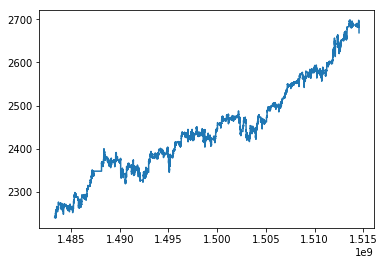

In [14]:
#A quick look at the dataframe time series using pyplot.plot(X_raw['SPXUSD']):
plt.plot(X_raw['SPXUSD'])

In [15]:
# Target
# We use as target one of the symbols rate, i.e. "EURUSD". That is we try to predict next value of EURUSD
lag = -1
y_raw = df2.loc[:,"EURUSD"].shift(periods=lag)

In [16]:
y_raw

timestamp
1483322400    1.05196
1483322700    1.05208
1483323000    1.05213
1483323300    1.05176
1483323600    1.05176
1483323900    1.05185
1483324200    1.05209
1483324500    1.05190
1483324800    1.05188
1483325100    1.05150
1483325400    1.05134
1483325700    1.05152
1483326000    1.05164
1483326300    1.05150
1483326600    1.05149
1483326900    1.05083
1483327200    1.05117
1483327500    1.05118
1483327800    1.05111
1483328100    1.05132
1483328400    1.05101
1483328700    1.05082
1483329000    1.05075
1483329300    1.04889
1483329600    1.04765
1483329900    1.04788
1483330200    1.04793
1483330500    1.04825
1483330800    1.04824
1483331100    1.04818
               ...   
1514557800    1.20086
1514558100    1.20092
1514558400    1.20082
1514558700    1.20085
1514559000    1.20078
1514559300    1.20092
1514559600    1.20078
1514559900    1.20080
1514560200    1.20080
1514560500    1.20050
1514560800    1.20059
1514561100    1.20051
1514561400    1.20044
1514561700    1.20020


In [17]:
#
# Removal of Null values**
# Now since there still exists 'NaN' values in our target dataframe, and these are Null values,
# we have to do something about them. In here, I will just do the naive thing of replacing these NaNs
# with previous value because it is only the last value an error is negligible as such:

# Filling gaps forward
y_raw = y_raw.fillna(method='pad')
y_raw

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram y_raw = data.drop(['timestamp'], 1)


timestamp
1483322400    1.05196
1483322700    1.05208
1483323000    1.05213
1483323300    1.05176
1483323600    1.05176
1483323900    1.05185
1483324200    1.05209
1483324500    1.05190
1483324800    1.05188
1483325100    1.05150
1483325400    1.05134
1483325700    1.05152
1483326000    1.05164
1483326300    1.05150
1483326600    1.05149
1483326900    1.05083
1483327200    1.05117
1483327500    1.05118
1483327800    1.05111
1483328100    1.05132
1483328400    1.05101
1483328700    1.05082
1483329000    1.05075
1483329300    1.04889
1483329600    1.04765
1483329900    1.04788
1483330200    1.04793
1483330500    1.04825
1483330800    1.04824
1483331100    1.04818
               ...   
1514557800    1.20086
1514558100    1.20092
1514558400    1.20082
1514558700    1.20085
1514559000    1.20078
1514559300    1.20092
1514559600    1.20078
1514559900    1.20080
1514560200    1.20080
1514560500    1.20050
1514560800    1.20059
1514561100    1.20051
1514561400    1.20044
1514561700    1.20020


## Define and Fit Model

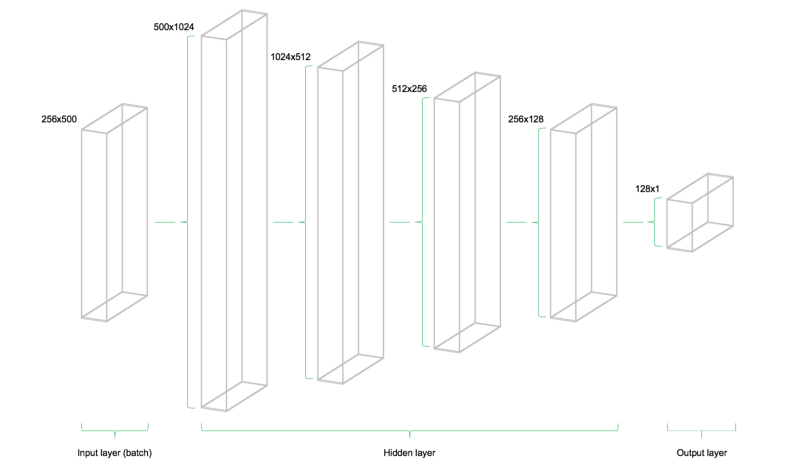

In [18]:
Image(filename='../docs/images/nn.png', width=800) 

In [19]:
# split into train and test sets

# Total samples
nsamples = n

# Splitting into train (70%) and test (30%) sets
split = 70 # training split% ; test (100-split)%
jindex = nsamples*split//100 # Index for slicing the samples

# Samples in train
nsamples_train = jindex

# Samples in test
nsamples_test = nsamples - nsamples_train
print("Total number of samples: ",nsamples,"\nSamples in train set: ", nsamples_train,
      "\nSamples in test set: ",nsamples_test)

# Here are train and test samples
X_train = X_raw.values[:jindex, :]
y_train = y_raw.values[:jindex]

X_test = X_raw.values[jindex:, :]
y_test = y_raw.values[jindex:]

print("X_train.shape = ", X_train.shape, "y_train.shape =", y_train.shape, "\nX_test.shape =  ",
      X_test.shape, "y_test.shape = ", y_test.shape)


Total number of samples:  104148 
Samples in train set:  72903 
Samples in test set:  31245
X_train.shape =  (72903, 31) y_train.shape = (72903,) 
X_test.shape =   (31245, 31) y_test.shape =  (31245,)


In [20]:
#X_train as dataframe (optional, only for printing. See note in the beginning)
X_Train = pd.DataFrame(data=X_train)
X_Train.columns = X_raw.columns
print("X_train")
X_Train

X_train


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.05155,1.03924,0.72074,84.258,1.07186,0.85184,122.966,1.25839,144.236,1.23400,...,1.51584,1.71140,1.65760,1.77865,0.93094,0.70579,80.960,15.883,1150.67,2241.00
1,1.05196,1.03898,0.72074,84.257,1.07207,0.85205,123.003,1.25753,144.287,1.23418,...,1.51584,1.71140,1.65811,1.77866,0.93108,0.70598,81.008,15.883,1150.67,2241.00
2,1.05208,1.03894,0.72067,84.252,1.07172,0.85213,123.005,1.25687,144.264,1.23402,...,1.51584,1.71140,1.65807,1.77839,0.93120,0.70569,81.010,15.883,1150.67,2241.00
3,1.05213,1.03894,0.72074,84.260,1.07168,0.85214,123.005,1.25679,144.265,1.23380,...,1.51584,1.71140,1.65807,1.77838,0.93120,0.70576,81.014,15.883,1150.67,2241.00
4,1.05176,1.03893,0.72074,84.286,1.07158,0.85186,123.004,1.25707,144.344,1.23389,...,1.51584,1.71140,1.65793,1.77821,0.93118,0.70575,81.038,15.883,1150.67,2241.00
5,1.05176,1.03892,0.72064,84.282,1.07153,0.85181,123.014,1.25705,144.341,1.23408,...,1.51584,1.71203,1.65839,1.77851,0.93133,0.70577,81.036,15.883,1150.67,2241.00
6,1.05185,1.03885,0.72064,84.285,1.07152,0.85195,123.022,1.25706,144.364,1.23427,...,1.51584,1.71210,1.65903,1.77807,0.93149,0.70560,81.048,15.883,1150.67,2241.00
7,1.05209,1.03849,0.72071,84.356,1.07192,0.85216,123.136,1.25740,144.453,1.23439,...,1.51584,1.71221,1.65896,1.77805,0.93167,0.70561,81.123,15.883,1150.67,2241.00
8,1.05190,1.03791,0.71988,84.253,1.07218,0.85190,123.104,1.25796,144.461,1.23437,...,1.51584,1.71394,1.65904,1.77926,0.93114,0.70587,81.098,15.883,1150.67,2241.00
9,1.05188,1.03744,0.71949,84.246,1.07221,0.85187,123.172,1.25812,144.546,1.23438,...,1.51584,1.71503,1.65914,1.77925,0.93115,0.70605,81.124,15.883,1150.67,2241.00


In [21]:
#X_test as dataframe (optional, only for printing. See note in the beginning)
X_Test = pd.DataFrame(data=X_test)
X_Test.columns = X_raw.columns
print("X_test")
X_Test

X_test


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.19577,1.10007,0.80282,88.101,1.14457,0.90203,131.227,1.26880,145.477,1.32559,...,1.63842,1.65109,1.60726,1.81634,0.88479,0.69846,80.077,17.791,1325.98,2490.75
1,1.19570,1.09984,0.80266,88.091,1.14424,0.90242,131.225,1.26786,145.416,1.32491,...,1.63846,1.65048,1.60632,1.81541,0.88470,0.69830,80.084,17.792,1325.96,2490.75
2,1.19539,1.09934,0.80260,88.067,1.14413,0.90213,131.167,1.26814,145.387,1.32495,...,1.63734,1.65077,1.60636,1.81484,0.88505,0.69870,80.099,17.805,1326.24,2490.75
3,1.19542,1.09916,0.80252,88.053,1.14451,0.90197,131.163,1.26881,145.410,1.32528,...,1.63726,1.65126,1.60743,1.81508,0.88550,0.69895,80.101,17.801,1326.08,2490.25
4,1.19565,1.09954,0.80256,88.055,1.14470,0.90177,131.185,1.26930,145.467,1.32581,...,1.63810,1.65185,1.60797,1.81646,0.88521,0.69874,80.078,17.791,1325.95,2490.63
5,1.19587,1.09932,0.80239,88.041,1.14484,0.90162,131.212,1.26974,145.523,1.32631,...,1.63839,1.65280,1.60804,1.81705,0.88487,0.69870,80.080,17.793,1326.36,2491.00
6,1.19557,1.09984,0.80233,88.037,1.14474,0.90166,131.185,1.26946,145.480,1.32585,...,1.63891,1.65243,1.60804,1.81743,0.88466,0.69843,80.037,17.786,1326.21,2490.50
7,1.19577,1.09974,0.80277,88.083,1.14493,0.90222,131.215,1.26894,145.425,1.32535,...,1.63808,1.65092,1.60723,1.81551,0.88525,0.69890,80.088,17.793,1326.24,2490.50
8,1.19606,1.09959,0.80282,88.064,1.14506,0.90225,131.203,1.26901,145.410,1.32560,...,1.63821,1.65105,1.60735,1.81558,0.88525,0.69890,80.080,17.792,1326.32,2490.50
9,1.19614,1.09953,0.80275,88.058,1.14519,0.90206,131.208,1.26944,145.449,1.32595,...,1.63819,1.65175,1.60777,1.81606,0.88523,0.69895,80.084,17.795,1326.37,2490.25


In [22]:
# Scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

y_train_std = sc.fit_transform(y_train.reshape(-1, 1))
y_test_std = sc.transform(y_test.reshape(-1, 1))

**Note**

Becareful not to write `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a great difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, this is not always the case in Forex market data, as has been well stablished in literature. The correct way is to re-use parameters from the training set if we are doing any kind of transformation. So, the test set should basically stand for "new, unseen" data.



In [23]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Train_std = pd.DataFrame(data=X_train_std)
X_Train_std.columns = X_Train.columns
print("X_train_std")
X_Train_std

X_train_std


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,-1.225727,-1.550004,-2.288970,-0.668220,-0.732291,-0.892755,-0.241048,0.469146,0.771293,-1.263736,...,-0.671319,1.158958,-0.199332,0.024044,-0.390921,0.157651,0.487205,-1.864446,-2.771756,-2.245806
1,-1.216916,-1.563565,-2.288970,-0.668765,-0.724208,-0.883544,-0.232340,0.416624,0.790001,-1.257513,...,-0.671319,1.158958,-0.188857,0.024267,-0.382920,0.171924,0.510828,-1.864446,-2.771756,-2.245806
2,-1.214337,-1.565652,-2.292662,-0.671493,-0.737679,-0.880035,-0.231870,0.376316,0.781564,-1.263045,...,-0.671319,1.158958,-0.189679,0.018262,-0.376061,0.150139,0.511813,-1.864446,-2.771756,-2.245806
3,-1.213262,-1.565652,-2.288970,-0.667128,-0.739218,-0.879596,-0.231870,0.371430,0.781931,-1.270651,...,-0.671319,1.158958,-0.189679,0.018039,-0.376061,0.155397,0.513781,-1.864446,-2.771756,-2.245806
4,-1.221214,-1.566173,-2.288970,-0.652943,-0.743067,-0.891878,-0.232105,0.388530,0.810909,-1.267539,...,-0.671319,1.158958,-0.192554,0.014259,-0.377204,0.154646,0.525593,-1.864446,-2.771756,-2.245806
5,-1.221214,-1.566695,-2.294244,-0.655126,-0.744991,-0.894071,-0.229751,0.387309,0.809808,-1.260970,...,-0.671319,1.174066,-0.183107,0.020931,-0.368632,0.156148,0.524609,-1.864446,-2.771756,-2.245806
6,-1.219280,-1.570346,-2.294244,-0.653489,-0.745376,-0.887930,-0.227868,0.387920,0.818245,-1.254401,...,-0.671319,1.175745,-0.169962,0.011145,-0.359487,0.143378,0.530515,-1.864446,-2.771756,-2.245806
7,-1.214122,-1.589123,-2.290552,-0.614752,-0.729981,-0.878719,-0.201038,0.408684,0.850891,-1.250252,...,-0.671319,1.178382,-0.171400,0.010700,-0.349200,0.144129,0.567427,-1.864446,-2.771756,-2.245806
8,-1.218205,-1.619374,-2.334327,-0.670948,-0.719975,-0.890123,-0.208569,0.442885,0.853826,-1.250944,...,-0.671319,1.219868,-0.169757,0.037611,-0.379491,0.163661,0.555123,-1.864446,-2.771756,-2.245806
9,-1.218635,-1.643889,-2.354896,-0.674767,-0.718820,-0.891439,-0.192565,0.452657,0.885005,-1.250598,...,-0.671319,1.246006,-0.167703,0.037388,-0.378919,0.177182,0.567919,-1.864446,-2.771756,-2.245806


In [24]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Test_std = pd.DataFrame(data=X_test_std)
X_Test_std.columns = X_Test.columns

print("X_test_std")
X_Test_std

X_test_std


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.873748,1.622760,2.039957,1.428472,2.066053,1.308785,1.703233,1.104915,1.226506,1.902905,...,1.707204,-0.287281,-1.233228,0.862272,-3.028479,-0.392989,0.052624,0.882497,2.191128,1.652235
1,1.872244,1.610764,2.031519,1.423016,2.053352,1.325892,1.702762,1.047507,1.204131,1.879395,...,1.707980,-0.301908,-1.252534,0.841589,-3.033623,-0.405009,0.056069,0.883937,2.190561,1.652235
2,1.865582,1.584685,2.028354,1.409922,2.049119,1.313171,1.689111,1.064607,1.193493,1.880778,...,1.686248,-0.294954,-1.251712,0.828912,-3.013620,-0.374960,0.063452,0.902653,2.198488,1.652235
3,1.866226,1.575296,2.024135,1.402284,2.063743,1.306153,1.688170,1.105526,1.201930,1.892187,...,1.684695,-0.283204,-1.229736,0.834250,-2.987901,-0.356180,0.064436,0.896894,2.193959,1.644431
4,1.871169,1.595116,2.026245,1.403375,2.071056,1.297380,1.693348,1.135452,1.222838,1.910512,...,1.700995,-0.269056,-1.218645,0.864941,-3.004475,-0.371955,0.053116,0.882497,2.190278,1.650362
5,1.875897,1.583642,2.017279,1.395737,2.076444,1.290800,1.699702,1.162324,1.243379,1.927799,...,1.706622,-0.246275,-1.217208,0.878063,-3.023907,-0.374960,0.054101,0.885376,2.201885,1.656137
6,1.869450,1.610764,2.014115,1.393555,2.072595,1.292555,1.693348,1.145223,1.227606,1.911895,...,1.716712,-0.255147,-1.217208,0.886514,-3.035909,-0.395243,0.032938,0.875299,2.197639,1.648333
7,1.873748,1.605548,2.037320,1.418652,2.079908,1.317119,1.700408,1.113465,1.207432,1.894608,...,1.700607,-0.291357,-1.233844,0.843813,-3.002189,-0.359936,0.058038,0.885376,2.198488,1.648333
8,1.879981,1.597724,2.039957,1.408285,2.084911,1.318435,1.697584,1.117740,1.201930,1.903251,...,1.703129,-0.288240,-1.231379,0.845370,-3.002189,-0.359936,0.054101,0.883937,2.200753,1.648333
9,1.881700,1.594595,2.036265,1.405012,2.089914,1.310101,1.698761,1.144002,1.216235,1.915352,...,1.702741,-0.271454,-1.222753,0.856045,-3.003332,-0.356180,0.056069,0.888256,2.202168,1.644431


In [25]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Train = pd.DataFrame(data=y_train)
y_Train

,0
0,1.05196
1,1.05208
2,1.05213
3,1.05176
4,1.05176
5,1.05185
6,1.05209
7,1.05190
8,1.05188
9,1.05150


In [26]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Test = pd.DataFrame(data=y_test)
y_Test

,0
0,1.19570
1,1.19539
2,1.19542
3,1.19565
4,1.19587
5,1.19557
6,1.19577
7,1.19606
8,1.19614
9,1.19592


In [27]:
#y_train_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Train_std = pd.DataFrame(data=y_train_std)
y_Train_std

,0
0,-1.216942
1,-1.214363
2,-1.213288
3,-1.221240
4,-1.221240
5,-1.219306
6,-1.214148
7,-1.218231
8,-1.218661
9,-1.226827


In [28]:
#y_test_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Test_std = pd.DataFrame(data=y_test_std)
y_Test_std

,0
0,1.872176
1,1.865513
2,1.866158
3,1.871101
4,1.875829
5,1.869382
6,1.873680
7,1.879912
8,1.881632
9,1.876904


In [29]:
# Number of symbols in training data
print("Number of symbols in training data")
n_symbols = X_train.shape[1]
print(n_symbols)

# Neurons
print("Neurons")
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
print(n_neurons_1,n_neurons_2,n_neurons_3,n_neurons_4)

# Session
print("Session")
net = tf.InteractiveSession()

# Placeholder
print("Placeholder")
X = tf.placeholder(dtype=tf.float32, shape=[None, n_symbols])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
print("Initializers")
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
print("Hidden weights")
W_hidden_1 = tf.Variable(weight_initializer([n_symbols, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

print("Output weights")
# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

print("Hidden layer")
# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

print("Output layer (transpose!)")
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
print("Cost function")
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
print("Optimizer")
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
print("Init")
net.run(tf.global_variables_initializer())

# Fit neural net
print("Fit neural net")
batch_size = 256
mse_train = []
mse_test = []


Number of symbols in training data
31
Neurons
1024 512 256 128
Session
Placeholder
Initializers
Hidden weights
Output weights
Hidden layer
Output layer (transpose!)
Cost function
Optimizer
Init
Fit neural net


In [30]:
Y

<tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>

In [31]:
X

<tf.Tensor 'Placeholder:0' shape=(?, 31) dtype=float32>

# Evaluate Model

In [32]:
#
# Creating gif using imageio to visulize the training process
# 
#

import imageio

VALID_EXTENSIONS = ('png', 'jpg')


def create_gif(filenames, duration):
    """
    Takes minimum two arguments duration of the gif frame and image need to created as gif
    Args:
        filenames:  files to construct the gif list.
        duration: frame duration 
    Returns:    file .gif
    """
    if not all(f.lower().endswith(VALID_EXTENSIONS) for f in filenames):
        print('Only png and jpg files allowed')
        sys.exit(1)

    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = '../docs/images/video/'+'Gif-%s.gif' % datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimwrite(output_file, images, duration=duration)



Run
epoch= 0
MSE Train:  1.04059e-05
MSE Test:  0.00108972
MSE Train:  3.88602e-05
MSE Test:  0.00162159
MSE Train:  1.66648e-05
MSE Test:  0.00104525
epoch= 1
MSE Train:  7.29312e-06
MSE Test:  0.00128259
MSE Train:  3.52268e-05
MSE Test:  0.00169847
MSE Train:  8.57138e-06
MSE Test:  0.00137738
epoch= 2
MSE Train:  8.25625e-06
MSE Test:  0.0013545
MSE Train:  1.68636e-05
MSE Test:  0.00151311
MSE Train:  0.000222038
MSE Test:  0.00252722
epoch= 3
MSE Train:  8.15824e-06
MSE Test:  0.00135927
MSE Train:  7.54737e-06
MSE Test:  0.00133932
MSE Train:  1.08459e-05
MSE Test:  0.00147664
epoch= 4
MSE Train:  4.71832e-05
MSE Test:  0.000960542
MSE Train:  7.51053e-06
MSE Test:  0.0013702
MSE Train:  7.34542e-06
MSE Test:  0.00136629
epoch= 5
MSE Train:  0.000141213
MSE Test:  0.00230175
MSE Train:  1.70368e-05
MSE Test:  0.00112212
MSE Train:  5.50111e-05
MSE Test:  0.00189523
epoch= 6
MSE Train:  8.29717e-06
MSE Test:  0.00125627
MSE Train:  2.60748e-05
MSE Test:  0.00103536
MSE Train:  7.

MSE Train:  7.38501e-06
MSE Test:  0.000761318
MSE Train:  6.93866e-06
MSE Test:  0.000861811
MSE Train:  1.67754e-05
MSE Test:  0.000647095
epoch= 56
MSE Train:  6.24596e-06
MSE Test:  0.000806959
MSE Train:  8.5439e-06
MSE Test:  0.000901128
MSE Train:  2.07872e-05
MSE Test:  0.00104712
epoch= 57
MSE Train:  1.22002e-05
MSE Test:  0.000687835
MSE Train:  1.24734e-05
MSE Test:  0.000683253
MSE Train:  7.36199e-05
MSE Test:  0.000452207
epoch= 58
MSE Train:  9.40989e-06
MSE Test:  0.000720993
MSE Train:  6.39596e-06
MSE Test:  0.000784529
MSE Train:  1.21917e-05
MSE Test:  0.000692174
epoch= 59
MSE Train:  3.10357e-05
MSE Test:  0.000569243
MSE Train:  9.17172e-06
MSE Test:  0.000719566
MSE Train:  6.22389e-06
MSE Test:  0.000836245
epoch= 60
MSE Train:  1.13154e-05
MSE Test:  0.000940208
MSE Train:  1.49037e-05
MSE Test:  0.000662205
MSE Train:  1.85757e-05
MSE Test:  0.000631517
epoch= 61
MSE Train:  6.40016e-06
MSE Test:  0.000855961
MSE Train:  1.29048e-05
MSE Test:  0.000673803
MS

MSE Train:  2.34733e-05
MSE Test:  0.000937243
epoch= 110
MSE Train:  7.02326e-06
MSE Test:  0.000634769
MSE Train:  6.58391e-05
MSE Test:  0.00116625
MSE Train:  4.77649e-05
MSE Test:  0.000441006
epoch= 111
MSE Train:  4.14649e-06
MSE Test:  0.000738837
MSE Train:  1.50643e-05
MSE Test:  0.000561877
MSE Train:  1.09317e-05
MSE Test:  0.00085713
epoch= 112
MSE Train:  4.86206e-06
MSE Test:  0.000765305
MSE Train:  9.52951e-06
MSE Test:  0.000604077
MSE Train:  4.0258e-06
MSE Test:  0.000736026
epoch= 113
MSE Train:  4.70845e-06
MSE Test:  0.000767549
MSE Train:  1.2177e-05
MSE Test:  0.000871321
MSE Train:  4.74826e-06
MSE Test:  0.000758028
epoch= 114
MSE Train:  4.70454e-06
MSE Test:  0.000773865
MSE Train:  4.24152e-06
MSE Test:  0.000749575
MSE Train:  1.11739e-05
MSE Test:  0.000860995
epoch= 115
MSE Train:  4.28117e-06
MSE Test:  0.000754555
MSE Train:  6.89146e-06
MSE Test:  0.000807053
MSE Train:  8.46258e-06
MSE Test:  0.000628304
epoch= 116
MSE Train:  1.18675e-05
MSE Test: 

epoch= 164
MSE Train:  3.87905e-06
MSE Test:  0.000422581
MSE Train:  2.85754e-06
MSE Test:  0.000375575
MSE Train:  1.5094e-05
MSE Test:  0.000534164
epoch= 165
MSE Train:  2.92281e-06
MSE Test:  0.000372408
MSE Train:  1.66702e-05
MSE Test:  0.000264678
MSE Train:  5.49278e-06
MSE Test:  0.000332242
epoch= 166
MSE Train:  3.15356e-06
MSE Test:  0.000366944
MSE Train:  1.14838e-05
MSE Test:  0.000293074
MSE Train:  8.60774e-06
MSE Test:  0.00030553
epoch= 167
MSE Train:  9.72755e-06
MSE Test:  0.000492642
MSE Train:  4.05396e-06
MSE Test:  0.000441437
MSE Train:  4.88795e-05
MSE Test:  0.000195223
epoch= 168
MSE Train:  5.25009e-06
MSE Test:  0.000456846
MSE Train:  3.05571e-06
MSE Test:  0.000376817
MSE Train:  8.183e-06
MSE Test:  0.00031927
epoch= 169
MSE Train:  5.87603e-06
MSE Test:  0.000332901
MSE Train:  8.69099e-06
MSE Test:  0.000495116
MSE Train:  3.96232e-05
MSE Test:  0.000219036
epoch= 170
MSE Train:  1.04824e-05
MSE Test:  0.000518347
MSE Train:  5.77808e-06
MSE Test:  

MSE Train:  3.30093e-06
MSE Test:  0.000284309
MSE Train:  5.69587e-05
MSE Test:  0.000476628
epoch= 219
MSE Train:  2.02678e-06
MSE Test:  0.000258886
MSE Train:  3.51215e-06
MSE Test:  0.00028775
MSE Train:  2.30563e-06
MSE Test:  0.000248082
epoch= 220
MSE Train:  1.33527e-05
MSE Test:  0.000202686
MSE Train:  4.16047e-06
MSE Test:  0.000287393
MSE Train:  1.84096e-05
MSE Test:  0.000194009
epoch= 221
MSE Train:  6.7077e-06
MSE Test:  0.000218874
MSE Train:  3.63954e-06
MSE Test:  0.000283173
MSE Train:  2.9204e-06
MSE Test:  0.000240172
epoch= 222
MSE Train:  5.78704e-06
MSE Test:  0.000301007
MSE Train:  4.08924e-06
MSE Test:  0.00029141
MSE Train:  4.86938e-06
MSE Test:  0.000225051
epoch= 223
MSE Train:  2.54977e-05
MSE Test:  0.000184895
MSE Train:  1.99074e-05
MSE Test:  0.000193153
MSE Train:  4.20211e-06
MSE Test:  0.000230166
epoch= 224
MSE Train:  6.90994e-06
MSE Test:  0.000217862
MSE Train:  8.3742e-06
MSE Test:  0.000208025
MSE Train:  3.78407e-06
MSE Test:  0.000286962

MSE Train:  2.04157e-06
MSE Test:  0.000246896
epoch= 273
MSE Train:  3.60154e-06
MSE Test:  0.000235667
MSE Train:  3.22902e-05
MSE Test:  0.000190626
MSE Train:  2.88659e-05
MSE Test:  0.000194536
epoch= 274
MSE Train:  9.34167e-06
MSE Test:  0.000321697
MSE Train:  2.0629e-06
MSE Test:  0.000277417
MSE Train:  8.32349e-06
MSE Test:  0.000318138
epoch= 275
MSE Train:  2.92855e-06
MSE Test:  0.000281204
MSE Train:  2.4279e-05
MSE Test:  0.000377872
MSE Train:  1.62946e-05
MSE Test:  0.000205052
epoch= 276
MSE Train:  1.52887e-05
MSE Test:  0.000340548
MSE Train:  1.08329e-05
MSE Test:  0.000331601
MSE Train:  2.07596e-06
MSE Test:  0.00027407
epoch= 277
MSE Train:  6.1025e-06
MSE Test:  0.000301799
MSE Train:  4.47931e-06
MSE Test:  0.000289185
MSE Train:  2.84894e-06
MSE Test:  0.000243924
epoch= 278
MSE Train:  1.74073e-06
MSE Test:  0.00027096
MSE Train:  9.22454e-06
MSE Test:  0.000217896
MSE Train:  5.81012e-05
MSE Test:  0.0001895
epoch= 279
MSE Train:  9.8452e-06
MSE Test:  0.0

epoch= 327
MSE Train:  1.39674e-06
MSE Test:  0.000273685
MSE Train:  3.11415e-06
MSE Test:  0.000252018
MSE Train:  1.29927e-05
MSE Test:  0.000354291
epoch= 328
MSE Train:  1.78087e-06
MSE Test:  0.000269555
MSE Train:  1.67583e-06
MSE Test:  0.000264989
MSE Train:  3.54378e-06
MSE Test:  0.000257263
epoch= 329
MSE Train:  3.36397e-06
MSE Test:  0.000256949
MSE Train:  2.12847e-05
MSE Test:  0.000224508
MSE Train:  2.1264e-06
MSE Test:  0.000262179
epoch= 330
MSE Train:  6.09682e-06
MSE Test:  0.000244941
MSE Train:  7.58345e-06
MSE Test:  0.000241179
MSE Train:  1.95115e-06
MSE Test:  0.000256467
epoch= 331
MSE Train:  1.2062e-06
MSE Test:  0.0002846
MSE Train:  1.20039e-06
MSE Test:  0.000278738
MSE Train:  1.12366e-05
MSE Test:  0.000228557
epoch= 332
MSE Train:  1.41221e-06
MSE Test:  0.000285544
MSE Train:  2.9942e-05
MSE Test:  0.000214382
MSE Train:  1.62046e-05
MSE Test:  0.000351496
epoch= 333
MSE Train:  2.3237e-05
MSE Test:  0.000379466
MSE Train:  3.12707e-06
MSE Test:  0

MSE Train:  2.23739e-05
MSE Test:  0.000464669
MSE Train:  1.37436e-05
MSE Test:  0.000433915
epoch= 382
MSE Train:  1.06799e-06
MSE Test:  0.000327834
MSE Train:  6.6036e-06
MSE Test:  0.000741197
MSE Train:  3.06242e-05
MSE Test:  0.000790978
epoch= 383
MSE Train:  2.04121e-05
MSE Test:  0.000753554
MSE Train:  2.20207e-06
MSE Test:  0.000730658
MSE Train:  3.35615e-06
MSE Test:  0.00074334
epoch= 384
MSE Train:  2.70732e-06
MSE Test:  0.000743152
MSE Train:  1.13697e-06
MSE Test:  0.000738639
MSE Train:  1.81378e-06
MSE Test:  0.000738548
epoch= 385
MSE Train:  6.10569e-06
MSE Test:  0.000736496
MSE Train:  6.69444e-06
MSE Test:  0.000748987
MSE Train:  1.14091e-06
MSE Test:  0.000730935
epoch= 386
MSE Train:  1.05471e-06
MSE Test:  0.000737015
MSE Train:  3.66354e-05
MSE Test:  0.000776976
MSE Train:  1.0174e-06
MSE Test:  0.000739372
epoch= 387
MSE Train:  1.21591e-06
MSE Test:  0.000738449
MSE Train:  1.76631e-06
MSE Test:  0.000734788
MSE Train:  3.97253e-06
MSE Test:  0.0007347

MSE Train:  3.65544e-05
MSE Test:  0.000782324
epoch= 436
MSE Train:  2.12277e-05
MSE Test:  0.00076392
MSE Train:  8.35742e-07
MSE Test:  0.000742016
MSE Train:  1.81232e-06
MSE Test:  0.000745258
epoch= 437
MSE Train:  1.48545e-06
MSE Test:  0.000743413
MSE Train:  1.33875e-06
MSE Test:  0.000740313
MSE Train:  3.88048e-06
MSE Test:  0.000740597
epoch= 438
MSE Train:  1.27501e-06
MSE Test:  0.000742418
MSE Train:  1.12828e-06
MSE Test:  0.000736157
MSE Train:  2.60425e-06
MSE Test:  0.000745436
epoch= 439
MSE Train:  5.52555e-06
MSE Test:  0.00075055
MSE Train:  1.37779e-05
MSE Test:  0.000760992
MSE Train:  1.44721e-05
MSE Test:  0.000758227
epoch= 440
MSE Train:  8.19208e-07
MSE Test:  0.00074328
MSE Train:  5.54163e-06
MSE Test:  0.00074789
MSE Train:  1.39993e-05
MSE Test:  0.000758703
epoch= 441
MSE Train:  5.33427e-06
MSE Test:  0.000748265
MSE Train:  1.67345e-05
MSE Test:  0.000766367
MSE Train:  3.58879e-05
MSE Test:  0.000793725
epoch= 442
MSE Train:  8.76341e-07
MSE Test: 

epoch= 490
MSE Train:  3.25398e-06
MSE Test:  0.000789442
MSE Train:  1.3575e-06
MSE Test:  0.000797964
MSE Train:  1.66827e-06
MSE Test:  0.000793246
epoch= 491
MSE Train:  4.25821e-06
MSE Test:  0.000805549
MSE Train:  1.20479e-06
MSE Test:  0.000792686
MSE Train:  7.46153e-06
MSE Test:  0.00081471
epoch= 492
MSE Train:  1.41299e-06
MSE Test:  0.000794626
MSE Train:  9.10287e-06
MSE Test:  0.000799213
MSE Train:  5.61184e-06
MSE Test:  0.000812071
epoch= 493
MSE Train:  8.99335e-07
MSE Test:  0.000796427
MSE Train:  5.82641e-06
MSE Test:  0.000811627
MSE Train:  1.85451e-06
MSE Test:  0.000803712
epoch= 494
MSE Train:  1.1353e-06
MSE Test:  0.000802108
MSE Train:  1.4554e-05
MSE Test:  0.000829192
MSE Train:  2.8694e-06
MSE Test:  0.00079626
epoch= 495
MSE Train:  5.85185e-06
MSE Test:  0.000814399
MSE Train:  1.616e-05
MSE Test:  0.000804807
MSE Train:  1.5369e-06
MSE Test:  0.000808092
epoch= 496
MSE Train:  2.89089e-05
MSE Test:  0.000818194
MSE Train:  6.85239e-06
MSE Test:  0.00

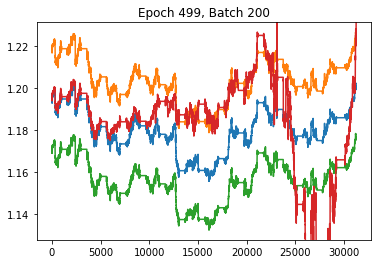

In [40]:
# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*1.02)
line3, = ax1.plot(y_test*0.98)
line4, = ax1.plot(y_test*0.99)
#plt.show() #Comment in jupyter notebook

#Create_gif function arguments
filenames = []
duration = 0.1

# Run
print("Run")
epochs = 500
for e in range(epochs):
    print("epoch=",e)
    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 100) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
 
            # Prediction
            #print("i=",i)
            pred = net.run(out, feed_dict={X: X_test})
            #print("pred=",pred)
            line4.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            file_name = '../docs/images/video/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
            #print(file_name)
            filenames.append(file_name)
            plt.savefig(file_name)
            plt.pause(0.01)

#Create a gif with the traing process
create_gif(filenames, duration)

# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)

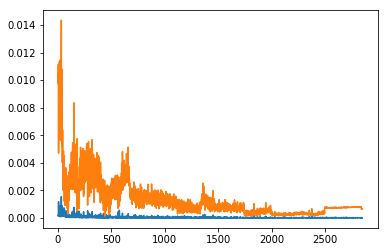

In [41]:
# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(mse_train[450:])
line2, = ax1.plot(mse_test[450:])
